In [ ]:
## ZAD 1

In [1]:
# Define utility classes:

class ChrPoint:

    def __init__(self, chr, pos):
        self.chr = chr
        self.pos = pos

    def __str__(self):
        return f'{self.chr} at {self.pos}'

class ChrRange:

    def __init__(self, chr, start, stop, range_type):
        self.chr = chr
        self.start = start
        self.stop = stop
        self.range_type = range_type

    def len(self):
        return self.stop - self.start + 1

    def __str__(self):
        return f'{self.chr} {self.start} {self.stop}'



In [2]:
# Read cpg islands
def parse_cpg_island(entry):
    split = entry.split()
    return ChrRange(split[1], int(split[2]), int(split[3]), 'island')

with open('cpgIslandExt.txt', 'r') as f:
    cpg_islands = [parse_cpg_island(line) for line in f.readlines()]
    cpg_islands = sorted(cpg_islands, key = lambda x: (x.chr, x.start) )

for x in cpg_islands[:10]:
    print(x)

chr1 28735 29810
chr1 135124 135563
chr1 327790 328229
chr1 437151 438164
chr1 449273 450544
chr1 533219 534114
chr1 544738 546649
chr1 713984 714547
chr1 762416 763445
chr1 788863 789211


In [3]:
# Filter autosomal only
import numpy as np

def filter_autosomal(x):
    autosomal_chromosomes = [f'chr{id}' for id in range(1, 23)]
    return [el for el in x if el.chr in autosomal_chromosomes]

cpg_islands = filter_autosomal(cpg_islands)

np.unique( [island.chr for island in cpg_islands])

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21',
       'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9'],
      dtype='<U5')

In [4]:
# Read chromosome sizes
with open('hg19.chrom.sizes', 'r') as f:
    chrom_sizes = { name: int(size) for name, size in [line.split() for line in f.readlines()]}

chrom_sizes

{'chr1': 249250621,
 'chr2': 243199373,
 'chr3': 198022430,
 'chr4': 191154276,
 'chr5': 180915260,
 'chr6': 171115067,
 'chr7': 159138663,
 'chrX': 155270560,
 'chr8': 146364022,
 'chr9': 141213431,
 'chr10': 135534747,
 'chr11': 135006516,
 'chr12': 133851895,
 'chr13': 115169878,
 'chr14': 107349540,
 'chr15': 102531392,
 'chr16': 90354753,
 'chr17': 81195210,
 'chr18': 78077248,
 'chr20': 63025520,
 'chrY': 59373566,
 'chr19': 59128983,
 'chr22': 51304566,
 'chr21': 48129895,
 'chr6_ssto_hap7': 4928567,
 'chr6_mcf_hap5': 4833398,
 'chr6_cox_hap2': 4795371,
 'chr6_mann_hap4': 4683263,
 'chr6_apd_hap1': 4622290,
 'chr6_qbl_hap6': 4611984,
 'chr6_dbb_hap3': 4610396,
 'chr17_ctg5_hap1': 1680828,
 'chr4_ctg9_hap1': 590426,
 'chr1_gl000192_random': 547496,
 'chrUn_gl000225': 211173,
 'chr4_gl000194_random': 191469,
 'chr4_gl000193_random': 189789,
 'chr9_gl000200_random': 187035,
 'chrUn_gl000222': 186861,
 'chrUn_gl000212': 186858,
 'chr7_gl000195_random': 182896,
 'chrUn_gl000223': 180

In [5]:
# Get shores and shelves


shore_size = 2000
shelf_size = 2000

def get_range(lower_bound, upper_bound, start, stop, chr, range_type):
    start = max(lower_bound, start)
    stop = min(upper_bound, stop)
    return ChrRange(chr, start, stop, range_type)

# divide range from start of chromosome to start of island
def divide_range_start_island(sea_start, island_start, chr):
    shore = get_range(sea_start, island_start - 1, island_start - shore_size, island_start - 1, chr, 'shore')
    shelf = get_range(sea_start, shore.start - 1, shore.start - shelf_size, shore.start - 1, chr, 'shelf')
    sea = get_range(sea_start, shelf.start - 1, sea_start, shelf.start - 1, chr, 'sea')
    return [sea, shelf, shore]

# divide range from end of island to end of chromosome
def divide_range_island_end(island_stop, sea_stop, chr):
    shore = get_range(island_stop + 1, sea_stop, island_stop + 1, island_stop + shore_size, chr, 'shore')
    shelf = get_range(shore.stop + 1, sea_stop, shore.stop + 1, shore.stop + shelf_size, chr, 'shelf')
    sea = get_range(shelf.stop + 1, sea_stop, shelf.stop + 1, sea_stop, chr, 'sea')
    return [shore, shelf, sea]
    
def divide_range_island_island(island_stop, island_start, chr):
    shore1 = get_range(island_stop + 1, island_start - 1, island_stop + 1, island_stop + shore_size, chr, 'shore')
    shore2 = get_range(shore1.stop + 1, island_start - 1, island_start - shore_size, island_start - 1, chr, 'shore')

    shelf1 = get_range(shore1.stop + 1, shore2.start - 1, shore1.stop + 1, shore1.stop + shelf_size, chr, 'shelf')
    shelf2 = get_range(shelf1.stop + 1, shore2.start - 1, shore2.start - shelf_size, shore2.start - 1, chr, 'shelf')
    
    sea = get_range(shelf1.stop + 1, shelf2.start - 1, shelf1.stop + 1, shelf2.start - 1, chr, 'sea')

    return [shore1, shelf1, sea, shelf2, shore2]

ranges_of_chromosomes = []

last_island = None

for island in cpg_islands:

    # start of chromosome
    if last_island is None:
        ranges = divide_range_start_island(0, island.start, island.chr)
    elif last_island.chr != island.chr:
        ranges = divide_range_island_end(last_island.stop, chrom_sizes[last_island.chr], last_island.chr)
        ranges += divide_range_start_island(0, island.start, island.chr)
    else:
        ranges = divide_range_island_island(last_island.stop, island.start, island.chr)

    ranges_of_chromosomes += ranges
    ranges_of_chromosomes.append(island)

    last_island = island

# that one last sea end
ranges = divide_range_island_end(last_island.stop, chrom_sizes[last_island.chr], last_island.chr)
ranges_of_chromosomes += ranges

for chr_range in ranges_of_chromosomes[:10]:
    print(chr_range, chr_range.range_type)

chr1 0 24734 sea
chr1 24735 26734 shelf
chr1 26735 28734 shore
chr1 28735 29810 island
chr1 29811 31810 shore
chr1 31811 33810 shelf
chr1 33811 131123 sea
chr1 131124 133123 shelf
chr1 133124 135123 shore
chr1 135124 135563 island


In [6]:
# filter ranges of length 0
def filter_empty_ranges(ranges):
    return [x for x in ranges if x.len() > 0]

print('was', len(ranges_of_chromosomes))

ranges_of_chromosomes = filter_empty_ranges(ranges_of_chromosomes)

print('is', len(ranges_of_chromosomes))

for chr_range in ranges_of_chromosomes[13060: 13301]:
    print(chr_range, chr_range.range_type)

was 159868
is 137539
chr1 249157420 249163407 sea
chr1 249163408 249165407 shelf
chr1 249165408 249167407 shore
chr1 249167408 249168010 island
chr1 249168011 249170010 shore
chr1 249170011 249172010 shelf
chr1 249172011 249196251 sea
chr1 249196252 249198251 shelf
chr1 249198252 249200251 shore
chr1 249200252 249200721 island
chr1 249200722 249202721 shore
chr1 249202722 249204721 shelf
chr1 249204722 249250621 sea
chr10 0 90525 sea
chr10 90526 92525 shelf
chr10 92526 94525 shore
chr10 94526 95301 island
chr10 95302 97301 shore
chr10 97302 99301 shelf
chr10 99302 115608 sea
chr10 115609 117608 shelf
chr10 117609 119608 shore
chr10 119609 120162 island
chr10 120163 122101 shore
chr10 122102 122620 island
chr10 122621 124620 shore
chr10 124621 126620 shelf
chr10 126621 176581 sea
chr10 176582 178581 shelf
chr10 178582 180581 shore
chr10 180582 182452 island
chr10 182453 184452 shore
chr10 184453 186452 shelf
chr10 186453 342503 sea
chr10 342504 344503 shelf
chr10 344504 346503 shore
chr

In [7]:
# save cpg, shores, seas and shelves

def save_ranges_of_type(ranges, range_type, filename):
    with open(filename, '+w') as f:
        for x in [r for r in ranges if r.range_type == range_type]:
            f.write(f'{x}\n')
    
save_ranges_of_type(ranges_of_chromosomes, 'island', 'my_cpg.bed')
save_ranges_of_type(ranges_of_chromosomes, 'shore', 'my_shores.bed')
save_ranges_of_type(ranges_of_chromosomes, 'shelf', 'my_shelves.bed')
save_ranges_of_type(ranges_of_chromosomes, 'sea', 'my_seas.bed')


## ZAD 2

In [8]:
# read methylation

import pybedtools

def parse_point(entry):
    return ChrPoint(entry[0], (int(entry[1]) + int(entry[2])) // 2)

methylation = pybedtools.BedTool('wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz')
methylation_coords = [ parse_point(entry) for entry in methylation]
methylation_coords = filter_autosomal(methylation_coords)

for point in methylation_coords[:10]:
    print(point)

chr16 at 53468137
chr3 at 37459231
chr3 at 171916062
chr1 at 91194699
chr8 at 42263319
chr14 at 69341164
chr16 at 28890125
chr8 at 41167827
chr1 at 230560818
chr15 at 23034472


## ZAD 3 

In [9]:
# sort methylations

methylation_coords = sorted(methylation_coords, key = lambda methylation: (methylation.chr, methylation.pos))

for m in methylation_coords[:10]:
    print(m)


chr1 at 15890
chr1 at 18852
chr1 at 29432
chr1 at 29450
chr1 at 29460
chr1 at 68874
chr1 at 69616
chr1 at 91575
chr1 at 135277
chr1 at 449101


In [10]:
# calcuate stats about methylation position

def is_pt_ahead(r, pt):
    return pt.chr > r.chr or ( r.chr == pt.chr  and pt.pos > r.start )

def is_in_range(r, pt):
     return r.chr == pt.chr and r.start <= pt.pos and pt.pos <= r.stop

def calculate_hits(methylation_coords, ranges):
    range_id = 0
    methylation_id = 0
    hits = {'island' : 0, 'shore': 0 , 'shelf' : 0, 'sea': 0}
    while range_id < len(ranges) and methylation_id < len(methylation_coords):
        
        if is_in_range( ranges[range_id], methylation_coords[methylation_id]):
            hits[ ranges[range_id].range_type ] += 1
            methylation_id += 1
        elif is_pt_ahead( ranges[range_id], methylation_coords[methylation_id]):
            range_id += 1
        else:
            print('erorororo')
            return -1
    
    return hits


all_hits = len(methylation_coords)

hits_stats = calculate_hits(methylation_coords, ranges_of_chromosomes)

print(all_hits)
print( sum( [ count for count in hits_stats.values()]))
print(hits_stats)
hits_stats_percents = { area: count / all_hits for area, count in hits_stats.items()}
print(hits_stats_percents)


470870
470870
{'island': 132325, 'shore': 122697, 'shelf': 45452, 'sea': 170396}
{'island': 0.2810223628602374, 'shore': 0.2605751056554888, 'shelf': 0.09652770403720771, 'sea': 0.36187482744706606}


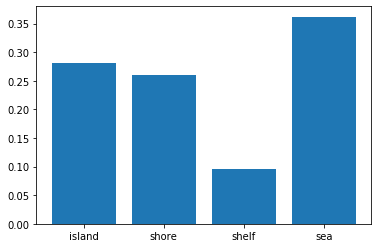

In [11]:
# plot results

import matplotlib.pyplot as plt

plt.bar(range(len(hits_stats_percents)), list(hits_stats_percents.values()), align='center')
plt.xticks(range(len(hits_stats_percents)), list(hits_stats_percents.keys()))

plt.show()